# Golomovzyi Viktor SA-32

In [1]:
import os
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset Combining

### Data concatenating

In [2]:
def standartize(df, column_map):
    """
    Standartize all column names.

    Args:
        df (DataFrame): DataFrame with raw data.
        column_map (Dict): Dictionary with standartized names.

    Returns:
        DataFrame: DataFrame with standartized column names.
    """
    standartized_columns = {}
    for col in df.columns:
        standartized_columns[col] = column_map.get(col, col)
        
    df.rename(columns = standartized_columns, inplace = True)

    return df

In [3]:
def detect_csv_format(file_path):
    """Detects various separators with built in python csv module.

    Args:
        file_path (str): Path to the DataFrame file.
    
    Returns:
        Dict: Dictionary with specified separator.
    """
    with open(file_path, 'r', encoding = 'utf-8') as file:
        sample = file.read(2048)
        sniffer = csv.Sniffer()
        dialect = sniffer.sniff(sample)

        return{'delimiter': dialect.delimiter, 'quotechar': dialect.quotechar}

In [ ]:
def preprocess(in_folder):
    """Mapping, renaming and standartizing columns in files.

    Args:
        in_folder (str): Input folder which contains data to preprocess.
    """

    concatenated_data = []

    column_map = {
        "Зарплата за місяць, net, після податків" : 'Salary',
        "Зарплата в месяц": 'Salary',
        "Зарплата у $$$ за місяць, лише ставка після сплати податків": 'Salary',
        "Зарплата.в.месяц": 'Salary',
        "salary": 'Salary',
        "Зарплата / дохід у $$$ за місяць, лише ставка після сплати податків": 'Salary',
        "Зарплата / дохід у $$$ за місяць, лише ставка \r\nЧИСТИМИ - після сплати податків": 'Salary',
        "Зарплата / дохід в ІТ у $$$ за місяць, лише ставка \r\nЧИСТИМИ - після сплати податків": 'Salary',
        "Зарплата / дохід в ІТ у $$$ за місяць, лише ставка \r\nЧИСТИМИ - після сплати податків": 'Salary',
        "Зарплата / дохід в IT у $$$ за місяць, лише ставка \r\nЧИСТИМИ - після сплати податків": 'Salary',

        "Оберіть вашу посаду": 'Position',
        "Должность": 'Position',
        "position": 'Position',
        "Оберіть вашу основну посаду": 'Position',
        "Спеціалізація": 'Position',
        "Position": 'Position',

        "Загальний стаж роботи за спеціальністю": 'Global_exp',
        "Стаж на поточному місці роботи": 'Local_exp',
        "Общий опыт работы": 'Global_exp',
        "Опыт работы на текущем месте": 'Local_exp',
        "exp": 'Global_exp',
        "current_job_exp": 'Local_exp',
        "Загальний стаж роботи в ІТ": 'Global_exp',
        "Загальний стаж роботи за нинішньою спеціалізацією": 'Global_exp',
        "Загальний стаж роботи за нинішньою ІТ-спеціальністю": 'Local_exp',
        "experience": 'Global_exp',
        "Ваш тайтл": 'Seniority',
        "Ваш тайтл на цій посаді": 'Seniority',
        "Оберіть ваш тайтл або роль у компанії": 'Seniority',
    }

    in_files = [file for file in os.listdir(in_folder) if file.endswith('.csv')]
    in_files = sorted(in_files, key = lambda x: int(re.search(r'\d+', x).group()))

    for file in in_files:
        match = re.search(r'(\d{4})_(\w+)_.*\.csv', file)
        year, month = match.groups()
        year = int(year)
        if month.lower() in ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'june']:
            half_year = f"{year}_H1"
        else:
            half_year = f"{year}_H2"
        path = os.path.join(in_folder, file)
        try:
            if half_year in ['2021_H2', '2022_H2', '2023_H1']:
                csv_format = {'delimiter': ';', 'quotechar': '"'}
            else:
                csv_format = detect_csv_format(path)

            df = pd.read_csv(path, on_bad_lines='skip', **csv_format)

            if half_year == "2022_H1":
                df = df[~((df.get("city") == "Всі міста") | (df.get("experience") == 'Весь досвід') | (df.get('position') == 'Всі'))]
            
            df.dropna(how='all', inplace = True)
            df = standartize(df, column_map)

            df['Period'] = half_year
            df = df.loc[:, ~df.columns.duplicated()]
            concatenated_data.append(df)

        except Exception as e:
            print(f"Error processing {file}: {e}")
        continue
    concat_df = pd.concat(concatenated_data, ignore_index = True)
    columns = ['Period', 'Position', 'Seniority', 'Global_exp', 'Local_exp', 'Salary']
    concat_df = concat_df[columns]
    concat_df.to_csv("concat_salary.csv", index = False)

### Data filtering

In [5]:
def seniority(exp):
    """Function that fills Seniority column of DataFrame based on expirience.

    Args:
        exp (str): Expirience, Global_exp or Local_exp.

    Returns:
        str: Processed and filled Seniority column.
    """
    jun = [x.strip().lower() for x in ['0.5', '0,25', '0,1', '0,5', '0.1', '0.25' ,'0.0', '1 рік', '3 місяці', 'Півроку', 'меньше 3 месяцев',  'Менше 3 місяців', '1.5', '1', '1.0', '1,5 року', '1-3 роки', 'До року', 'Junior', 'Intern/Trainee', 'Intern / Trainee', 'Немає тайтлу', 'Менше як 3 місяці', 'Пів року']]
    mid = [x.strip().lower() for x in ['3 роки', '5 років', '4 роки', '2 роки', '4', '2', '5', '3', '5.0', '3.0', '2.0', '4.0', '4-6 років', 'Middle']]
    senior = [x.strip().lower() for x in ['7 років', '6 років', '7', '6', '7.0', '6.0', '7-10 років', 'Senior', 'Staff']]
    lead = [x.strip().lower() for x in ['13', '10', '12', '11.0', '11', '13.0', '15', '14', '15.0', '12.0', '14.0', '10 і більше років', '9 років', '8 років', '10 и более лет', '9', '8', '10.0', '8.0', '9.0', '10 років', '11 років', '15 і більше років', '12 років', '14 років', '13 років', '10+ років', '15  і більше років', 'Tech Lead', 'Team Lead', 'Architect', 'Manager', 'Head', 'Lead/Team Lead', 'CEO / C-level (Chief) / Director / VP', 'Principal']]
    

    if pd.isna(exp) or str(exp).strip() == "": return None


    s = str(exp).strip().lower()
    if s in jun:
        return 'Junior'
    elif s in mid:
        return 'Middle'
    elif s in senior:
        return 'Senior'
    elif s in lead:
        return 'Lead'
    return s

In [6]:
def salary(sal):
      """Function to standartize Salary column of DataFrame.

      Args:
            sal (object): Salary column.

      Returns:
            float: float Salary column.
      """

      sal = str(sal).strip()

      if '-' in sal:
                  minimum, maximum = sal.split('-')
                  sal = (float(minimum.strip()) + float(maximum.strip()))/2
                  return float(sal)

      if ',' in sal:
            sal = sal.replace(',', '.')
            return float(sal)

      if '+' in sal:
            sal = float(sal.replace('+', '')) + 100
            return float(sal)

      return float(sal)

In [7]:
def filter(in_file):
    """Function that filters and normalizes dataframe: Seniority, Position, Salary columns.

    Args:
        in_file (file): Input dataframe file to filter.
    """
    df = pd.read_csv(in_file, dtype={'Global_exp': str, 'Local_exp': str, 'Seniority': str}, low_memory= False)

    # df = df[df['Position'].str.contains("Analyst", na = False, case = False)]
    # print(df['Position'].unique())
    # print(df['Global_exp'].unique())
    # print(set(df['Local_exp'].dropna().astype(str).str.strip()) - set(df['Global_exp'].dropna().astype(str).str.strip()))
    # print(df['Seniority'].unique())
    
    df['Position'] = df['Position'].astype(str).str.strip().str.replace('"', '')
    Pos = [
        'Business Analyst',
        'Business analyst',
        'Analyst (Business, Data, System)',
        'Analyst (Business, Data, System etc)',
        'BA (Business Analyst)',
    ]
    df = df[df['Position'].apply(lambda x: any(pos.lower() == x.lower() for pos in Pos))].sort_values(by = 'Period')

    df['Seniority'] = df.apply(lambda row: seniority(str(row['Local_exp'])) 
        if pd.isna(row['Global_exp']) or str(row['Global_exp']).strip().lower() in ['nan', 'none', ''] 
        else seniority(str(row['Global_exp'])),axis=1)
    
    df['Salary'] = df['Salary'].apply(salary)
    if df['Salary'].dtype == float or df['Salary'].dtype == np.float64:
        df['Salary'] = df['Salary'].astype(int)
    df.to_csv('filtered_salary.csv', index = False)
filter('concat_salary.csv')

## Economical data

In [8]:
def GDP(in_file):
    """Function creates new column in DataFrame and fills it with GDP value.

    Args:
        in_file (DataFrame): Input file with filtered salary.
    """
    df = pd.read_csv(in_file)
    df_filtered_salary = pd.read_csv('filtered_salary.csv')
    df = df[df['Country Name'] == 'Ukraine']
    df = df.melt(
        id_vars=["Country Name"],
        value_vars=[str(year) for year in range(2014, 2025)],
        var_name="Year",
        value_name="GDP"
    )
    df = df.dropna(subset=["GDP"])
    df = pd.concat([df, pd.DataFrame([{"Country Name": 'Ukraine', "Year": '2024', "GDP": 5711.16}])], ignore_index = True)
    df = df.drop(columns = ['Country Name'])
    df['Year'] = df['Year'].astype(str)

    df_H1 = df.copy()
    df_H1['Year'] = df_H1['Year'] + '_H1'

    df_H2 = df.copy()
    df_H2['Year'] = df_H2['Year'] + '_H2'

    df = pd.concat([df_H1, df_H2], ignore_index= True).sort_values(by = 'Year')
    df.rename(columns = {'Year': 'Period'}, inplace = True)


    df = df_filtered_salary.merge(df, on = 'Period', how = 'left')
    df['Period'] = df['Period'].str.replace('_H1', '.06').str.replace('_H2', '.12').astype(float)
    df.to_csv('filtered_salary_gdp.csv', index = False)

In [9]:
def additional_economics(CPI, IT, FSG):
    df_cpi = pd.read_csv(CPI)
    df_IT = pd.read_csv(IT)
    df_filtered = pd.read_csv(FSG)
    df = pd.merge(df_cpi, df_IT, on=['Year', 'Period'])
    df['Year'] = df.apply(lambda row: row['Year'] + 0.06 if row['Period'] == 'H1' else row['Year'] + 0.12, axis=1)
    df = df.drop(columns=['Period'])
    df.rename(columns = {'Year': 'Period'}, inplace = True)
    df = df.merge(df_filtered, on = 'Period', how = 'left')
    df = df[df['Period'] != 2015.06]
    df.to_csv("Additional_economics.csv", index= False)
additional_economics('CPI.csv', 'IT_exports.csv', 'filtered_salary_gdp.csv')

#### Графік зарплат

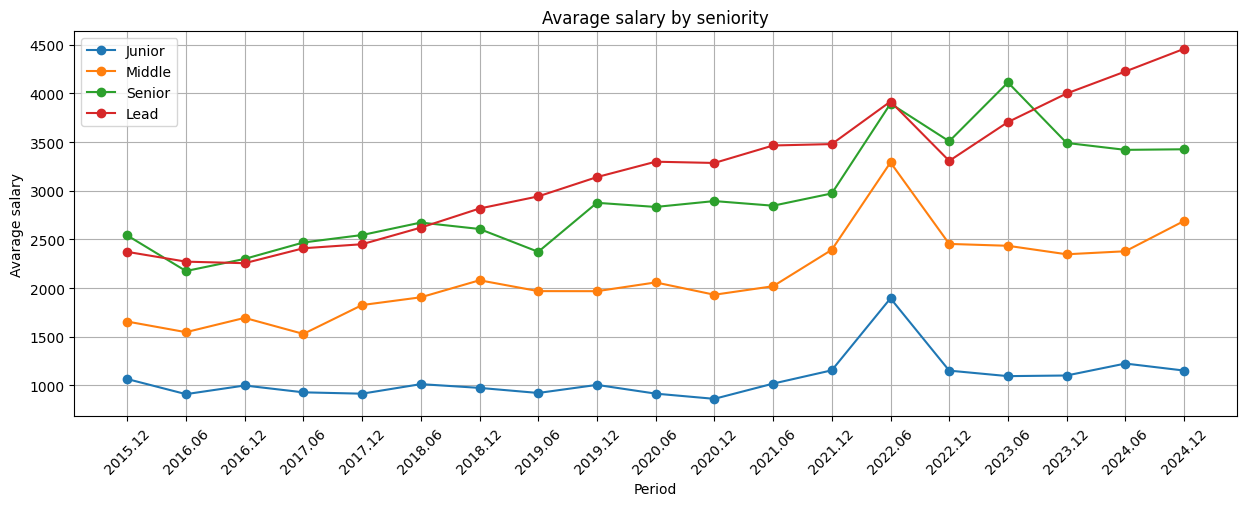

In [10]:
def avg_salary(in_file):
    """Calculates avarage salary, creates new DataFrame with grouped 
    seniority and avarage salary for every seniority in column by period.
    Shows graph of avarage salary by period.

    Args:
        in_file (DataFrame): Input DataFrame filtered file with gdp values.
    """
    df = pd.read_csv(in_file)
    df.drop(columns = ['Position', 'Local_exp', 'Global_exp'], inplace = True)
    df = df.groupby(['Period', 'Seniority', 'IT_Exports', 'CPI', 'GDP'], as_index = False).agg({'Salary':'mean'})

    df.to_csv('avg_salary.csv', index = False)

    df['Period_plot'] = df['Period'].apply(lambda p: (int(str(p).split('.')[0]) + (int(str(p).split('.')[1][:2]) - 1) / 12) if '.' in str(p) else int(p))


    plt.figure(figsize = (15, 5))

    for seniority in ['Junior', 'Middle', 'Senior', 'Lead']:
        subset = df[df['Seniority'] == seniority]
        plt.plot(subset['Period_plot'], subset['Salary'], marker = 'o', label = seniority)
    plt.title('Avarage salary by seniority')
    plt.xlabel('Period')
    plt.ylabel('Avarage salary')
    plt.xticks(df['Period_plot'].unique(), df['Period'].unique(), rotation = 45)
    plt.grid()
    plt.legend()
    plt.show()
    
avg_salary('Additional_economics.csv')

# Main Function

In [11]:
def main(preprocess, filter, GDP, additional_economics):
    """Main function to run the preprocess.

    Args:
        preprocess (func): Function that preprocesses the data from files.
        filter (func): Function that filters the data from preprocessed dataset.
    """
    print('Preprocessing files...')
    preprocess("salary_raw")
    print('Preprocess ended')
    
    print('Filtering DataFrame...')
    filter('concat_salary.csv')
    print('Finished to filter')

    print('Adding GDP per capita data...')
    GDP('GDP.csv')
    print('New DataFrame created')

    additional_economics('CPI.csv', 'IT_exports.csv', 'filtered_salary_gdp.csv')

if __name__ == '__main__':
    main(preprocess, filter, GDP, additional_economics)

Preprocessing files...
Preprocess ended
Filtering DataFrame...
Finished to filter
Adding GDP per capita data...
New DataFrame created
